# Model selection
The topology of an artificial neural network has to be optimized to obtain the model wich generalizes the best. This notebook is an introduction to the process of model selection. During this laboratory, you will be able to learn how to use the tools for empirically finding the best topology of an artificial neural network and the parameters of the learning algorithm.

## Loading the packages

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import sys
from ipywidgets import interact, widgets

%matplotlib inline

## The dataset
This function creates a dataset with two classes in two dimensions. It has two parameters: the size of the dataset and the spread of each one of the classes. A high spread value makes both classes to superpose, making the classification more difficult.

In [2]:
def create_dataset(n, s):
    n1 = int(np.ceil(n / 2.0))
    n2 = int(np.floor(n / 2.0))
    x1 = np.random.normal(-1, s, n1)
    y1 = np.random.uniform(-1, 1,  n1)
    x2 = np.random.normal(1, s, n2)
    y2 = np.random.uniform(-1, 1, n2)
    return np.stack((np.concatenate((x1, x2)), np.concatenate((y1, y2)), np.concatenate((np.ones(n1), -1*np.ones(n2)))), 1)

In [3]:
def plot_dataset(s):
    dataset = create_dataset(200, s)
    pl.scatter(dataset[:,0], dataset[:,1], c=[(['b', 'r'])[int(cl > 0)] for cl in dataset[:,2]])
    pl.xlim(-3,3)
    pl.ylim(-1,1)
    pl.grid()

In [4]:
interact(plot_dataset, s=widgets.FloatSlider(value=0.1, min=0.1, max=1.0, step=0.01, description='Spread:',));

interactive(children=(FloatSlider(value=0.1, description='Spread:', max=1.0, min=0.1, step=0.01), Output()), _…

## The MLP
Import the code of the backpropagation with momentum algorithm

In [5]:
import mlp_backprop_momentum as mlp

## Cross-validation
Import the code of the cross-valdidation test

In [6]:
import k_fold_cross_validation as cv

## Dataset
Create a dataset to perform the test

In [7]:
# DATASET_SIZE = 200
# SPREAD = 0.7
# dataset = create_dataset(DATASET_SIZE, SPREAD)

# Load the vowel dataset
import numpy as np
from python_speech_features import mfcc
from matplotlib import pyplot as pl
import os
import scipy.io.wavfile as wav
PATH = '../vowels'
import glob


nam_paths = glob.glob(os.path.join(PATH, 'nam*.wav'))
naf_paths = glob.glob(os.path.join(PATH, 'naf*.wav'))
nk_paths = glob.glob(os.path.join(PATH, 'nk*.wav'))

naf_audios = [wav.read(path) for path in naf_paths]
nam_audios = [wav.read(path) for path in nam_paths]
nk_audios = [wav.read(path) for path in nk_paths]

# creates an array with all the mfccs of all samples

nafMfccList = [mfcc(i[1], samplerate=i[0], nfft=1024) for i in naf_audios]
namMfccList = [mfcc(i[1], samplerate=i[0], nfft=1024) for i in nam_audios]
nkMfccList = [mfcc(i[1], samplerate=i[0], nfft=1024) for i in nk_audios]

# normalization functions
def norm_0_1(data):
    min = np.min(data)
    max = np.max(data)
    for i in range(len(data)):
        for j in range(13):
            data[i, j] = (data[i, j] - min)/(max - min)
    return data

def norm_min_1_plus_1(data):
    min = np.min(data)
    max = np.max(data)
    for i in range(len(data)):
        for j in range(13):
            data[i, j] = (2*(data[i, j] - min)/(max - min))-1
    return data
    

# computes the median of each mfcc
naf_mfcc_median = np.array([np.median(j, 0) for j in nafMfccList])
nam_mfcc_median = np.array([np.median(j, 0) for j in namMfccList])
nk_mfcc_median = np.array([np.median(j, 0) for j in nkMfccList])

# normalization
#naf_mfcc_median = norm_min_1_plus_1(naf_mfcc_median)
#nam_mfcc_median = norm_min_1_plus_1(naf_mfcc_median)
#nk_mfcc_median = norm_min_1_plus_1(nk_mfcc_median)

"""
pl.scatter(dataset[:,0], dataset[:,1], c=[(['b', 'r'])[int(cl > 0)] for cl in dataset[:,2]])
pl.xlim(-3,3)
pl.ylim(-1,1)
pl.grid()
"""



"\npl.scatter(dataset[:,0], dataset[:,1], c=[(['b', 'r'])[int(cl > 0)] for cl in dataset[:,2]])\npl.xlim(-3,3)\npl.ylim(-1,1)\npl.grid()\n"

In [8]:
naf_mfcc_median.shape


(36, 13)

In [9]:
nam_mfcc_median.shape


(36, 13)

In [10]:
nk_mfcc_median.shape

(108, 13)

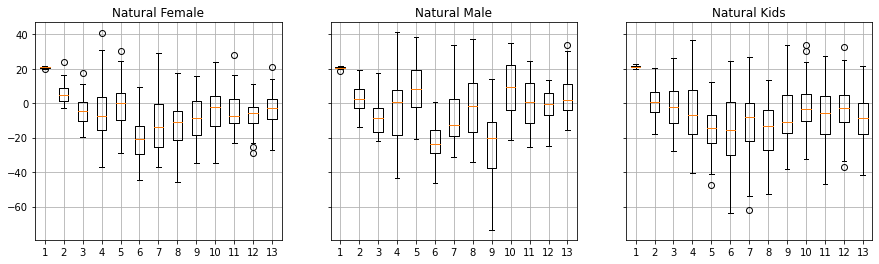

In [11]:
# Boxplot of the 3 medians of the MFCCs

f, (ax1, ax2, ax3) = pl.subplots(1,3, sharey='all', figsize=(15,4))
ax1.plot()
ax1.boxplot(naf_mfcc_median)
ax1.set_title('Natural Female')
ax1.grid()
ax2.boxplot(nam_mfcc_median)
ax2.set_title('Natural Male')
ax2.grid()
ax3.boxplot(nk_mfcc_median)
ax3.set_title('Natural Kids')
ax3.grid()

In [24]:
# Concatenation of male, female, kids

mfccs = np.concatenate((
    nam_mfcc_median,
    naf_mfcc_median#,
    #nk_mfcc_median
))

print(mfccs.shape)

classes = np.concatenate(
    (
        np.repeat(-1, len(nam_mfcc_median)),
        np.repeat(1, len(naf_mfcc_median))#,
       # np.repeat(2, len(nk_mfcc_median))
    )
)

print(len(nam_mfcc_median))
print(len(naf_mfcc_median))

mfccs_norm = norm_min_1_plus_1(mfccs)

# randomize order
random_order = np.random.permutation(mfccs.shape[0])

mfccs_norm = mfccs_norm[random_order]
classes = classes[random_order]

dataset = np.insert(mfccs_norm, 13, classes, axis=1)

print(dataset)
print(classes)

(72, 13)
36
36
[[ 0.65186687  0.3613584   0.08898129 ... -0.016845    0.1269014
   1.        ]
 [ 0.64217781  0.37558746  0.23893006 ...  0.14637122  0.19920813
   1.        ]
 [ 0.64276331  0.29378702 -0.06785017 ...  0.49129062  0.21139412
  -1.        ]
 ...
 [ 0.65419152  0.10703735  0.22075397 ... -0.14892504  0.11667398
  -1.        ]
 [ 0.64001338  0.37604163  0.17014085 ...  0.02875236  0.8110916
  -1.        ]
 [ 0.64072384  0.25627271  0.21206744 ...  0.51291785  0.06372519
  -1.        ]]
[ 1  1 -1 -1  1  1 -1 -1  1  1 -1  1 -1  1  1  1 -1  1 -1  1 -1 -1  1  1
  1 -1  1  1 -1  1  1 -1 -1  1  1  1 -1  1 -1  1  1  1 -1  1 -1 -1  1 -1
  1  1 -1  1  1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1 -1  1 -1 -1  1 -1 -1 -1]


In [13]:
print(dataset)

[[ 0.62985342  0.44022764  0.03155042 ...  0.23189279  0.11211814
   1.        ]
 [ 0.64510466  0.43692317  0.10307509 ...  0.46604983  0.2560721
   1.        ]
 [ 0.63402227  0.4330951   0.29999892 ...  0.10083651  0.10291712
   1.        ]
 ...
 [ 0.64654052  0.29116839  0.2074334  ...  0.21432238  0.12357399
   1.        ]
 [ 0.65305597  0.27586305  0.11359719 ...  0.00396143  0.16927963
   1.        ]
 [ 0.63945177  0.36438574  0.36522978 ...  0.16690615  0.68841384
  -1.        ]]


## Exploring the number of epochs
Let's first try to estimate how many iterations of the backpropagation algorithm are enough to find a low training error. We fixed the learning rate to `0.001` and the momentum term to `0.5`. These values are just initial guesses which work well in most of the cases. Feel free to change these values if:

+ the error curve oscillates -> reduce the learning rate
+ the error curve is very smooth and does not change -> increase the learning rate
+ the model does not converge -> try different values of momentum

This initial test is performed by only tracking the training error. Hence, it is impossible to know if the model overfits or not. We will only know if the model's complexity is enough for learning the task.

The following snippet also changes the number of hidden neurons from the simplest model possible (2 neurons) to a model having a complexity you think is excesive. Model selection in artificial neural networks is based on the experience. Moreover, notice that the MLPs are initialized several times to avoid a too bad result due to an unlucky initialization.

In [385]:
N_INITS = 10
EPOCHS = 50
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.0009
MOMENTUM = 0.9

In [386]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping over the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_INITS):                                        # looping over the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((dataset[:,0:13], dataset[:,13:14]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


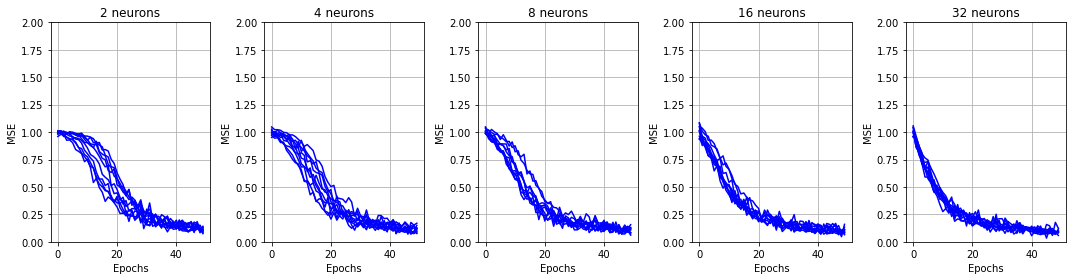

In [387]:
pl.figure(figsize=(15,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,2)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

In every case, from 2 to 32 neurons in the hidden layer, the training error does not improve anymore after 50 iterations. The result of this test indicates that the minimum number of iterations needed are around 20 iterations (Taking into account only the training error!).

## Exploring the number of hidden neurons
Knowing that there are no significant improvements after 50 iterations, we can now further explore how the complexity of the model (number of hidden neurons) is linked to the generalization performance (test error). The following snippet allows you to explore both the number of epochs and the number of hidden neurons without restarting the training.

In [388]:
EPOCHS = 100
K = 5
N_TESTS = 10
N_NEURONS = [2, 4]#, 6, 8, 10, 15, 20, 25, 30]

In [389]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_TESTS):                                        # looping the tests
        nn.init_weights()                                               # the network has to be reinitialized before each test
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,         # notice that we do not use cv.k_fold_cross_validation
                                                            dataset,    # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,        # returns a value of error per each epoch
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        # temp1 and temp2 are the training and test error. One value per epoch
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2

Testing 2 neurons...
Testing 4 neurons...


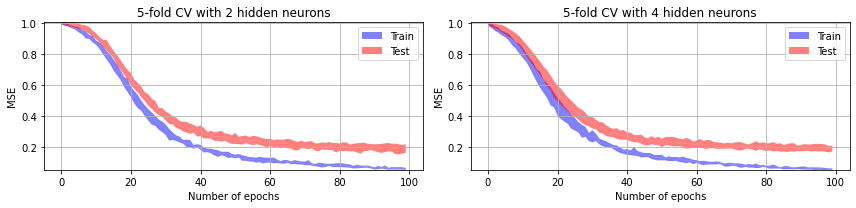

In [390]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(v_min, v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

Notice that the test error does not improve much between 40 and 60 iterations, neither adding more hidden neurons after 4 units. 

The following snippet shows a different visualization.

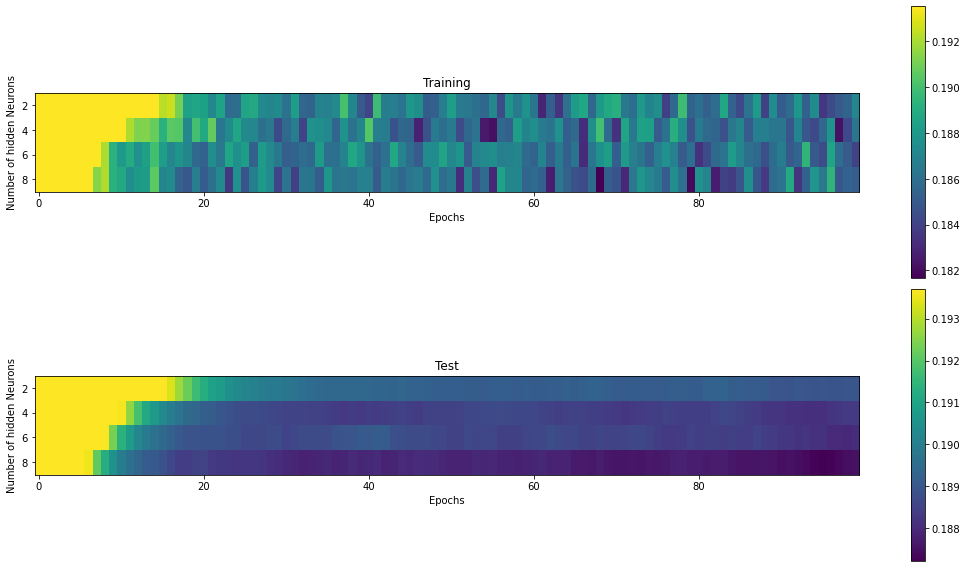

In [25]:
pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train_mean, vmin=np.min(MSE_train_mean), vmax=np.percentile(MSE_train_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test_mean, vmin=np.min(MSE_test_mean), vmax=np.percentile(MSE_test_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

For this particular problem, having more hidden neurons or running the backpropagation algorithm longer does not affect negatively the performance of the model. However, more iterations implies more processing time and more neurons implies more ressources and this should be avoided.

## The final model
An artificial neural network with 2 neurons and 40 iterations of the backpropagation algorithm is enough to solve the problem.

In [26]:
nn = mlp.MLP([13,2,1], 'tanh')

In [27]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataset,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=100,
                                                          threshold=0.0)

In [28]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)

MSE training:  0.05901502295851542
MSE test:  0.17818341663144874
Confusion matrix:
[[34.  2.]
 [ 3. 33.]]


### Ajout des enfants

In [35]:
# Concatenation of male, female, kids

mfccs = np.concatenate((
    nam_mfcc_median,
    naf_mfcc_median,
    nk_mfcc_median
))


print(mfccs_norm.shape)
c1 = np.concatenate(
    (
        np.repeat(1, len(nam_mfcc_median)),
        np.repeat(0, len(naf_mfcc_median)),
        np.repeat(0, len(nk_mfcc_median))
    )
)
c2 = np.concatenate(
    (
        np.repeat(0, len(nam_mfcc_median)),
        np.repeat(1, len(naf_mfcc_median)),
        np.repeat(0, len(nk_mfcc_median))
    )
)
c3 = np.concatenate(
    (
        np.repeat(0, len(nam_mfcc_median)),
        np.repeat(0, len(naf_mfcc_median)),
        np.repeat(1, len(nk_mfcc_median))
    )
)

c1 = np.reshape(c1, (len(c1), 1))
c2 = np.reshape(c2, (len(c2), 1))
c3 = np.reshape(c3, (len(c3), 1))

classes = np.concatenate(
    (
        c1,
        c2,
        c3
    ), axis=1
)

mfccs_norm = norm_min_1_plus_1(mfccs)

# randomize order
random_order = np.random.permutation(mfccs.shape[0])
mfccs_norm = mfccs_norm[random_order]

classes = classes[random_order]

# Colonnes 13:16 de dataset = classes. 100 = m, 010 = f, 001 = k
dataset = np.insert(mfccs_norm, 13, classes[:,0], axis=1)
dataset = np.insert(dataset, 14, classes[:,1], axis=1)
dataset = np.insert(dataset, 15, classes[:,2], axis=1)

print(dataset)
print(classes)

(180, 13)
[[ 0.64457191  0.32277308 -0.05281757 ...  1.          0.
   0.        ]
 [ 0.65674986  0.15804138  0.05515561 ...  0.          0.
   1.        ]
 [ 0.66138018  0.20528988  0.0564436  ...  0.          0.
   1.        ]
 ...
 [ 0.65755772  0.15337818  0.28707516 ...  0.          0.
   1.        ]
 [ 0.6483317   0.42732913 -0.05553306 ...  0.          1.
   0.        ]
 [ 0.67128665  0.19634167  0.17322313 ...  0.          0.
   1.        ]]
[[1 0 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 

In [36]:
N_INITS = 10
EPOCHS = 100
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.0009
MOMENTUM = 0.9

In [37]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping over the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,3], 'logistic')
    for i in np.arange(N_INITS):                                        # looping over the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((dataset[:,0:13], dataset[:,13:16]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


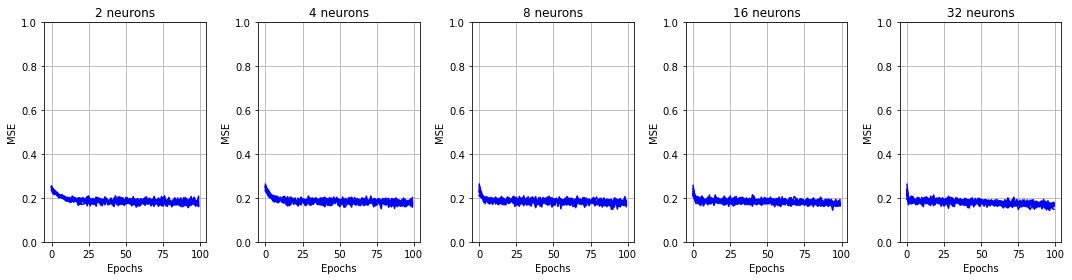

In [38]:
pl.figure(figsize=(15,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

#### Exploring the number of hidden neurons

In [39]:
EPOCHS = 100
K = 5
N_TESTS = 10
N_NEURONS = [2, 4, 6, 8]#, 10, 15, 20, 25, 30]

In [40]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,3], 'logistic')
    for i in np.arange(N_TESTS):                                        # looping the tests
        nn.init_weights()                                               # the network has to be reinitialized before each test
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,         # notice that we do not use cv.k_fold_cross_validation
                                                            dataset,    # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,        # returns a value of error per each epoch
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        # temp1 and temp2 are the training and test error. One value per epoch
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2

Testing 2 neurons...
Testing 4 neurons...
Testing 6 neurons...
Testing 8 neurons...


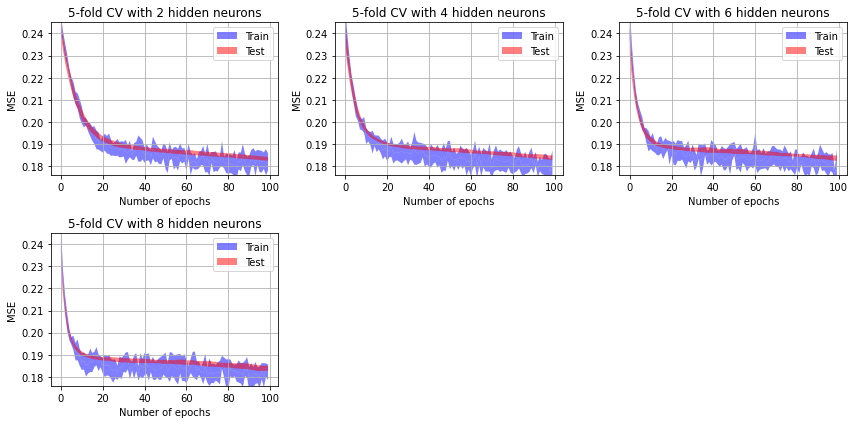

In [41]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(v_min, v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

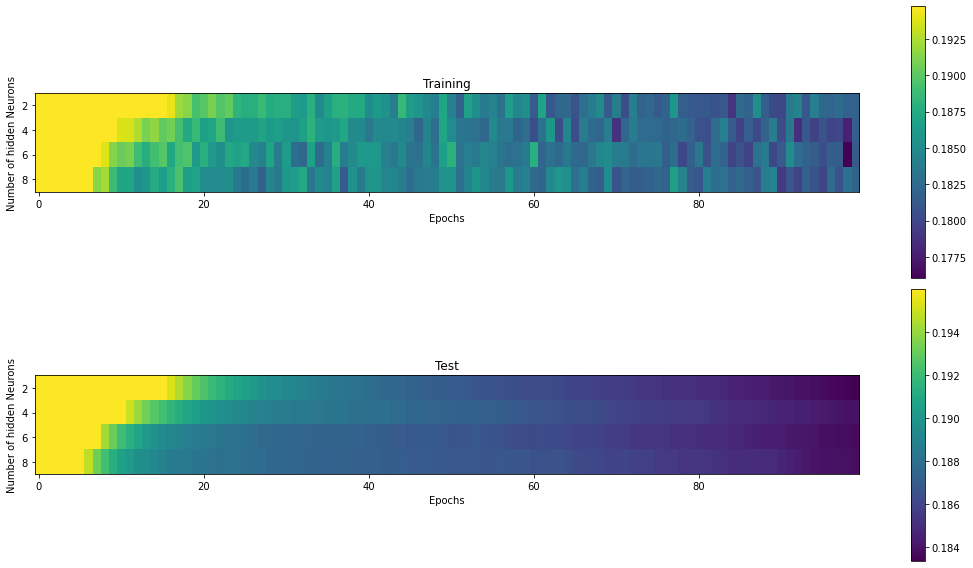

In [42]:
pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train_mean, vmin=np.min(MSE_train_mean), vmax=np.percentile(MSE_train_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test_mean, vmin=np.min(MSE_test_mean), vmax=np.percentile(MSE_test_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

#### Final model

In [48]:
nn = mlp.MLP([13,2,3], 'logistic')

In [49]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataset,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=150,
                                                          threshold=0.5)

In [50]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)

MSE training:  0.1760830650471876
MSE test:  0.18060380560709727
Confusion matrix:
[[  0.   0.  36.]
 [  0.   0.  36.]
 [  0.   0. 108.]]


# Ajout synthé

In [51]:
# DATASET_SIZE = 200
# SPREAD = 0.7
# dataset = create_dataset(DATASET_SIZE, SPREAD)

# Load the vowel dataset
import numpy as np
from python_speech_features import mfcc
from matplotlib import pyplot as pl
import os
import scipy.io.wavfile as wav
PATH = '../vowels'
import glob


nam_paths = glob.glob(os.path.join(PATH, 'nam*.wav'))
naf_paths = glob.glob(os.path.join(PATH, 'naf*.wav'))
nk_paths = glob.glob(os.path.join(PATH, 'nk*.wav'))

sam_paths = glob.glob(os.path.join(PATH, 'sam*.wav'))
saf_paths = glob.glob(os.path.join(PATH, 'saf*.wav'))
sk_paths = glob.glob(os.path.join(PATH, 'sk*.wav'))

naf_audios = [wav.read(path) for path in naf_paths]
nam_audios = [wav.read(path) for path in nam_paths]
nk_audios = [wav.read(path) for path in nk_paths]

saf_audios = [wav.read(path) for path in saf_paths]
sam_audios = [wav.read(path) for path in sam_paths]
sk_audios = [wav.read(path) for path in sk_paths]

# creates an array with all the mfccs of all samples

nafMfccList = [mfcc(i[1], samplerate=i[0], nfft=1024) for i in naf_audios]
namMfccList = [mfcc(i[1], samplerate=i[0], nfft=1024) for i in nam_audios]
nkMfccList = [mfcc(i[1], samplerate=i[0], nfft=1024) for i in nk_audios]

safMfccList = [mfcc(i[1], samplerate=i[0], nfft=1024) for i in saf_audios]
samMfccList = [mfcc(i[1], samplerate=i[0], nfft=1024) for i in sam_audios]
skMfccList = [mfcc(i[1], samplerate=i[0], nfft=1024) for i in sk_audios]

# computes the median of each mfcc
naf_mfcc_median = np.array([np.median(j, 0) for j in nafMfccList])
nam_mfcc_median = np.array([np.median(j, 0) for j in namMfccList])
nk_mfcc_median = np.array([np.median(j, 0) for j in nkMfccList])

saf_mfcc_median = np.array([np.median(j, 0) for j in safMfccList])
sam_mfcc_median = np.array([np.median(j, 0) for j in samMfccList])
sk_mfcc_median = np.array([np.median(j, 0) for j in skMfccList])

"""
pl.scatter(dataset[:,0], dataset[:,1], c=[(['b', 'r'])[int(cl > 0)] for cl in dataset[:,2]])
pl.xlim(-3,3)
pl.ylim(-1,1)
pl.grid()
"""



"\npl.scatter(dataset[:,0], dataset[:,1], c=[(['b', 'r'])[int(cl > 0)] for cl in dataset[:,2]])\npl.xlim(-3,3)\npl.ylim(-1,1)\npl.grid()\n"

In [52]:
saf_mfcc_median.shape
sam_mfcc_median.shape
sk_mfcc_median.shape
naf_mfcc_median.shape
nam_mfcc_median.shape
nk_mfcc_median.shape

(108, 13)

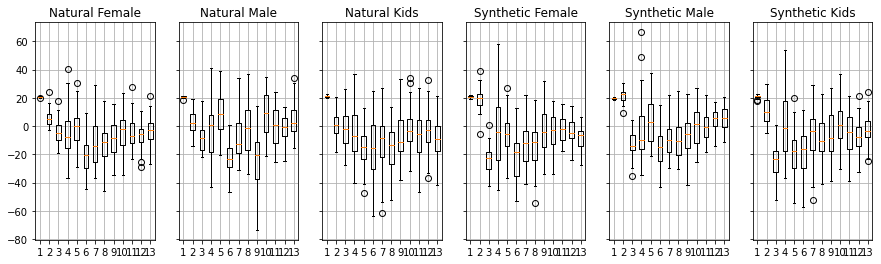

In [53]:
# Boxplot of the 6 medians of the MFCCs

f, (ax1, ax2, ax3, ax4, ax5, ax6) = pl.subplots(1,6, sharey='all', figsize=(15,4))
ax1.plot()
ax1.boxplot(naf_mfcc_median)
ax1.set_title('Natural Female')
ax1.grid()
ax2.boxplot(nam_mfcc_median)
ax2.set_title('Natural Male')
ax2.grid()
ax3.boxplot(nk_mfcc_median)
ax3.set_title('Natural Kids')
ax3.grid()
ax4.boxplot(saf_mfcc_median)
ax4.set_title('Synthetic Female')
ax4.grid()
ax5.boxplot(sam_mfcc_median)
ax5.set_title('Synthetic Male')
ax5.grid()
ax6.boxplot(sk_mfcc_median)
ax6.set_title('Synthetic Kids')
ax6.grid()

In [54]:
# Concatenation of male, female, kids

mfccs = np.concatenate((
    nam_mfcc_median,
    naf_mfcc_median,
    nk_mfcc_median,
    sam_mfcc_median,
    saf_mfcc_median,
    sk_mfcc_median   
))

print(mfccs.shape)

classes = np.concatenate(
    (
        np.repeat(-1, len(nam_mfcc_median)),
        np.repeat(-1, len(naf_mfcc_median)),
        np.repeat(-1, len(nk_mfcc_median)),
         np.repeat(1, len(sam_mfcc_median)),
        np.repeat(1, len(saf_mfcc_median)),
        np.repeat(1, len(sk_mfcc_median))
    )
)

mfccs_norm = norm_min_1_plus_1(mfccs)

# randomize order
random_order = np.random.permutation(mfccs.shape[0])

mfccs_norm = mfccs_norm[random_order]
classes = classes[random_order]

dataset = np.insert(mfccs_norm, 13, classes, axis=1)

print(dataset)
print(classes)

(360, 13)
[[ 0.33003407  0.07233637  0.07968097 ...  0.03921669 -0.13465761
  -1.        ]
 [ 0.3553466   0.20670977 -0.24598592 ...  0.186613   -0.16245014
   1.        ]
 [ 0.34597719  0.32512778  0.06304943 ... -0.41640631 -0.17991862
   1.        ]
 ...
 [ 0.35425751  0.11466429 -0.09230223 ... -0.27910203 -0.11074668
  -1.        ]
 [ 0.3374874   0.42257409 -0.05771689 ... -0.05010458 -0.04526227
   1.        ]
 [ 0.33951961  0.28272989  0.0391115  ...  0.20669318  0.02463513
  -1.        ]]
[-1  1  1 -1 -1  1  1  1  1 -1  1  1  1 -1  1  1  1  1 -1  1  1 -1  1 -1
  1 -1  1  1 -1 -1  1  1 -1  1  1 -1 -1 -1  1 -1  1 -1 -1  1 -1 -1 -1 -1
  1 -1 -1 -1 -1 -1  1  1  1 -1  1  1  1  1 -1 -1  1 -1  1  1 -1  1 -1  1
  1 -1  1 -1  1  1  1  1 -1  1  1 -1  1 -1 -1  1  1  1 -1 -1  1 -1  1 -1
  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1  1  1 -1  1 -1  1  1
  1  1 -1 -1 -1  1 -1  1  1  1 -1  1  1 -1  1 -1 -1  1  1 -1  1 -1  1 -1
  1  1  1 -1 -1  1 -1 -1  1 -1 -1  1 -1 -1 -1 -1  1  1  1 -1

In [55]:
print(dataset)

[[ 0.33003407  0.07233637  0.07968097 ...  0.03921669 -0.13465761
  -1.        ]
 [ 0.3553466   0.20670977 -0.24598592 ...  0.186613   -0.16245014
   1.        ]
 [ 0.34597719  0.32512778  0.06304943 ... -0.41640631 -0.17991862
   1.        ]
 ...
 [ 0.35425751  0.11466429 -0.09230223 ... -0.27910203 -0.11074668
  -1.        ]
 [ 0.3374874   0.42257409 -0.05771689 ... -0.05010458 -0.04526227
   1.        ]
 [ 0.33951961  0.28272989  0.0391115  ...  0.20669318  0.02463513
  -1.        ]]


In [62]:
N_INITS = 10
EPOCHS = 150
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.0008
MOMENTUM = 0.5

In [63]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping over the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_INITS):                                        # looping over the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((dataset[:,0:13], dataset[:,13:14]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


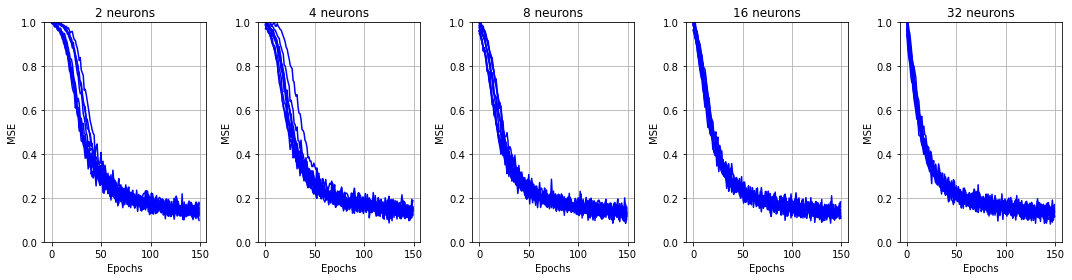

In [64]:
pl.figure(figsize=(15,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

In [67]:
EPOCHS = 200
K = 5
N_TESTS = 2
N_NEURONS = [2, 4, 6, 8]#, 10, 15, 20, 25, 30]

In [68]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_TESTS):                                        # looping the tests
        nn.init_weights()                                               # the network has to be reinitialized before each test
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,         # notice that we do not use cv.k_fold_cross_validation
                                                            dataset,    # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,        # returns a value of error per each epoch
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        # temp1 and temp2 are the training and test error. One value per epoch
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2

Testing 2 neurons...
Testing 4 neurons...
Testing 6 neurons...
Testing 8 neurons...


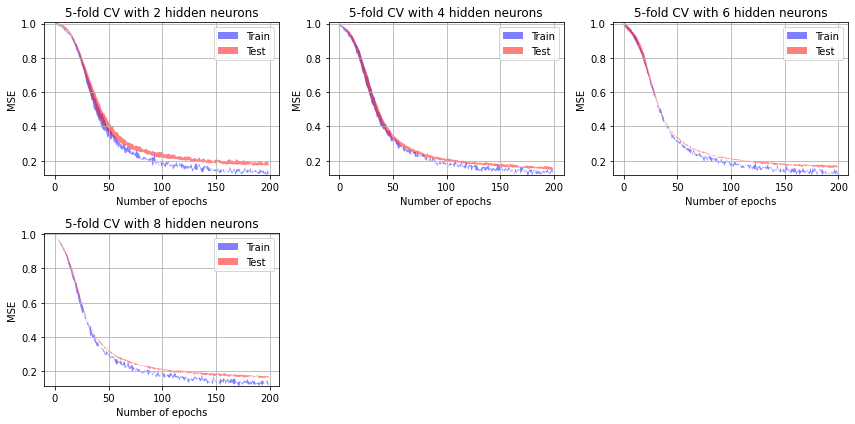

In [69]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(v_min, v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

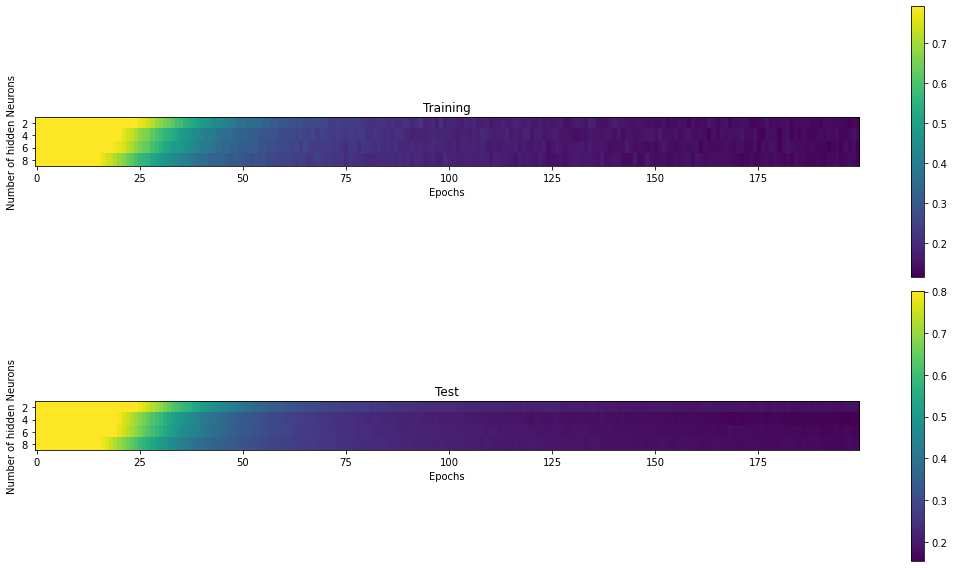

In [70]:
pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train_mean, vmin=np.min(MSE_train_mean), vmax=np.percentile(MSE_train_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test_mean, vmin=np.min(MSE_test_mean), vmax=np.percentile(MSE_test_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

In [71]:
nn = mlp.MLP([13,2,1], 'tanh')

In [72]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataset,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=250,
                                                          threshold=0.0)

In [73]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)

MSE training:  0.12012370859086838
MSE test:  0.15383503249177605
Confusion matrix:
[[176.   4.]
 [ 12. 168.]]
